
*   Deep Learning 
*   Problem - Binary Classification
*   Dataset - Hotel Cancellation Prediction
*   Model - Created by own (CNN)
*   Major Tools - Google Colab (Jupyter Notebook, Tensorflow, Keras)


Import libraries

In [20]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D,MaxPooling2D, Activation, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
drive_path = '/content/drive/MyDrive/data/'

In [11]:
!unzip -q '/content/gdrive/MyDrive/data/hotel_bookings.csv.zip'

Read dataset using pandas

In [12]:
# link for dataset - https://www.kaggle.com/aayushaswal/hotel-cancellation-prediction/data

pd.pandas.set_option('display.max_columns',None) # Displays all columns of dataframe
dataset = pd.read_csv('/content/hotel_bookings.csv')
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [13]:
#dataset.describe()
#dataset.info()
dataset.shape #(rows, columns)

(119390, 32)

Separate feature variables(inputs) ie X and Target variables(output) ie y

In [14]:
X = dataset.copy()
y = X.pop('is_canceled')

print(X.shape)
print(y.shape)

(119390, 31)
(119390,)


Preprocessing

In [15]:
X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )

features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

X and y after preprocessing

In [16]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(89542, 63)
(89542,)
(29848, 63)
(29848,)


Define number of inputs

In [17]:
input_shape = [X_train.shape[1]]

Create or import model

In [21]:
model = Sequential([
    BatchNormalization(input_shape=input_shape),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid'),
])

1.   Compile model - define optimizer, loss and matric
2.   Print summary of model.

In [23]:
optimizer = Adam(learning_rate=0.0001)

model.compile(
    optimizer = optimizer,
    loss = 'binary_crossentropy',
    metrics = ['binary_accuracy'],
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_3 (Batc  (None, 63)               252       
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 256)               16384     
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_5 (Batc  (None, 256)             

In [24]:
checkpoint_path = drive_path + 'weights.h5' 
logger_path = drive_path + 'logger.csv'

Checkpoint will save only best weights which gave best val_binary_accuracy and define logger file


In [28]:
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                              monitor="val_binary_accuracy",
                              mode="max",
                              save_best_only=True,
                            )

logger = CSVLogger(logger_path, append=True, separator=',')

Early stopping of below parameters says/meaning : "If there hasn't been at least an improvement of 0.001 in the validation loss over the previous 5 epochs, then stop the training and keep the best model you found." (To avoid overfittitng)

In [27]:
early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

Run model for training

In [29]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    verbose=1,
    callbacks=[early_stopping,checkpoint,logger],
)

Epoch 1/200
175/175 [==============================] - 6s 20ms/step - loss: 0.5980 - binary_accuracy: 0.6897 - val_loss: 0.4728 - val_binary_accuracy: 0.7782
Epoch 2/200
175/175 [==============================] - 3s 18ms/step - loss: 0.5030 - binary_accuracy: 0.7581 - val_loss: 0.4334 - val_binary_accuracy: 0.7961
Epoch 3/200
175/175 [==============================] - 3s 18ms/step - loss: 0.4801 - binary_accuracy: 0.7719 - val_loss: 0.4253 - val_binary_accuracy: 0.8019
Epoch 4/200
175/175 [==============================] - 3s 18ms/step - loss: 0.4692 - binary_accuracy: 0.7766 - val_loss: 0.4203 - val_binary_accuracy: 0.8040
Epoch 5/200
175/175 [==============================] - 3s 18ms/step - loss: 0.4580 - binary_accuracy: 0.7834 - val_loss: 0.4175 - val_binary_accuracy: 0.8065
Epoch 6/200
175/175 [==============================] - 4s 20ms/step - loss: 0.4513 - binary_accuracy: 0.7860 - val_loss: 0.4144 - val_binary_accuracy: 0.8088
Epoch 7/200
175/175 [==============================]

Print graph

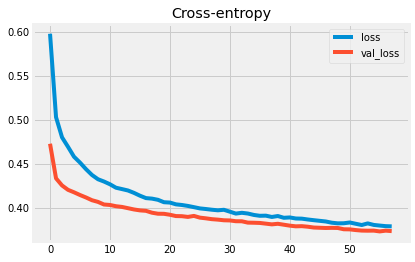

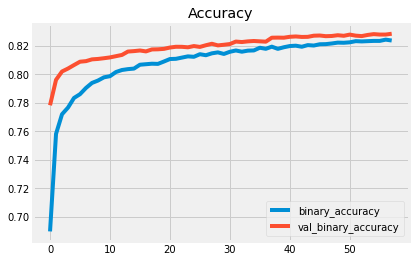

In [30]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Loss")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

Load best saved weights

In [32]:
model.load_weights(checkpoint_path)

Evaluate model / Testing model

In [34]:
loss, acc = model.evaluate(X_valid, y_valid)
print("Model accuracy: {:5.2f}%".format(100 * acc))

933/933 [==============================] - 2s 2ms/step - loss: 0.3739 - binary_accuracy: 0.8268
Model accuracy: 82.68%


Prediction of model

In [35]:
predictions = model.predict(X_valid)

# Convert prediction into classes for binary classification, if prediction more than 0.5 then 1 or 0
predictions = (predictions > 0.5).astype("int32")

Verify prediction

In [40]:
select_ip = 45

print(f'Prediction of Given Input : {predictions[select_ip]}')
print(f'Actual label of Given Input : {y_valid.values[select_ip]}')

if predictions[select_ip] == y_valid.values[select_ip]:
  print(f'Predicted Correctly')
else:
  print(f'Predicted Incorrectly')

Prediction of Given Input : [0]
Actual label of Given Input : 0
Predicted Correctly
